## Setup

In [24]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from src.regex_pattern_generator import generate_regex_patterns


# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [25]:
PHRASES = ['Deal',
'Million / Billion / Trillion',
'Israel / Gaza / Hamas',
'China',
'Biden',
'Mugged',
'Tremendous',
'Tariff',
'Seven Wars',
'Stupid',
'Crypto / Bitcoin',
"Women's sports",
'TikTok',
'Butler',
'Country was dead / Dead country']

SEARCH_PHRASES = generate_regex_patterns(PHRASES)

from pprint import pprint
pprint(SEARCH_PHRASES)

{'Biden': "\\b(?:\\w+-)*(?:biden|bidens|biden's|bidens')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Butler': "\\b(?:\\w+-)*(?:butler|butlers|butler's|butlers')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'China': "\\b(?:\\w+-)*(?:china|chinas|china's|chinas')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Country was dead / Dead country': "\\b(?:\\w+-)*(?:(?:country[\\s,\\-]+was[\\s,\\-]+dead|country[\\s,\\-]+was[\\s,\\-]+deads|country[\\s,\\-]+was[\\s,\\-]+dead's|country[\\s,\\-]+was[\\s,\\-]+deads'|country[\\s,\\-]+were[\\s,\\-]+dead|country[\\s,\\-]+were[\\s,\\-]+deads|country[\\s,\\-]+were[\\s,\\-]+dead's|country[\\s,\\-]+were[\\s,\\-]+deads'|country[\\s,\\-]+was's[\\s,\\-]+dead|country[\\s,\\-]+was's[\\s,\\-]+deads|country[\\s,\\-]+was's[\\s,\\-]+dead's|country[\\s,\\-]+was's[\\s,\\-]+deads'|country[\\s,\\-]+wass'[\\s,\\-]+dead|country[\\s,\\-]+wass'[\\s,\\-]+deads|country[\\s,\\-]+wass'[\\s,\\-]+dead's|country[\\s,\\-]+wass'[\\s,\\-]+deads'|country[\\s,\\-]+were'[\\s,\\-]+dead|country[\\s,\\-]+were'[\\s,\\-]+deads|cou

In [26]:
INAUGURATION_DATE = datetime(2025, 1, 20)
CONTEXT_WINDOW = 200 # words to display for context

In [27]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process transcripts from speech and sotu directories only"""
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'category': category,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    
    return pd.DataFrame(results)


In [28]:
# Process transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Create dataframes for different subsets
df = df[(df['category'] != 'sotu') & (df['category'] != 'press briefing')]
df_all_post = df[df['date'] >= INAUGURATION_DATE]
df_interviews = df[df['category'] == 'interview']
df_non_category = df[df['category'] != 'interview']
df_interviews_post = df[(df['category'] == 'interview') & (df['date'] >= INAUGURATION_DATE)]

# Print dataset statistics
print("Dataset Statistics:")
print("\nAll Transcripts:")
print(f"Total: {len(df)}")
print(f"Post-inauguration: {len(df_all_post)}")
print(f"Average length: {df['text_length'].mean():.0f} words")
print(f"Post-inauguration average length: {df_all_post['text_length'].mean():.0f} words")

print("\nInterviews Only:")
print(f"Total: {len(df_interviews)}")
print(f"Post-inauguration: {len(df_interviews_post)}")
print(f"Average length: {df_interviews['text_length'].mean():.0f} words")
print(f"Post-inauguration average length: {df_interviews_post['text_length'].mean():.0f} words")

print("\nDate Ranges:")
print("All Transcripts:")
print(f"Full range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_all_post['date'].min().strftime('%Y-%m-%d')} to {df_all_post['date'].max().strftime('%Y-%m-%d')}")

print("\nInterviews:")
print(f"Full range: {df_interviews['date'].min().strftime('%Y-%m-%d')} to {df_interviews['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_interviews_post['date'].min().strftime('%Y-%m-%d')} to {df_interviews_post['date'].max().strftime('%Y-%m-%d')}")


Categories found in directory:
- donald trump vlog
- interview
- interview - pending
- press briefing
- press conference
- press gaggle
- processed-transcripts
- remarks
- sotu
- speech
- un-addresses
- uncategorized
Dataset Statistics:

All Transcripts:
Total: 641
Post-inauguration: 365
Average length: 5148 words
Post-inauguration average length: 3368 words

Interviews Only:
Total: 57
Post-inauguration: 34
Average length: 4399 words
Post-inauguration average length: 4408 words

Date Ranges:
All Transcripts:
Full range: 2017-09-19 to 2025-09-14
Post-inauguration: 2025-01-20 to 2025-09-14

Interviews:
Full range: 2024-05-04 to 2025-09-12
Post-inauguration: 2025-01-22 to 2025-09-12


In [29]:
df_category = df_interviews

## Phrase Frequency Over Time


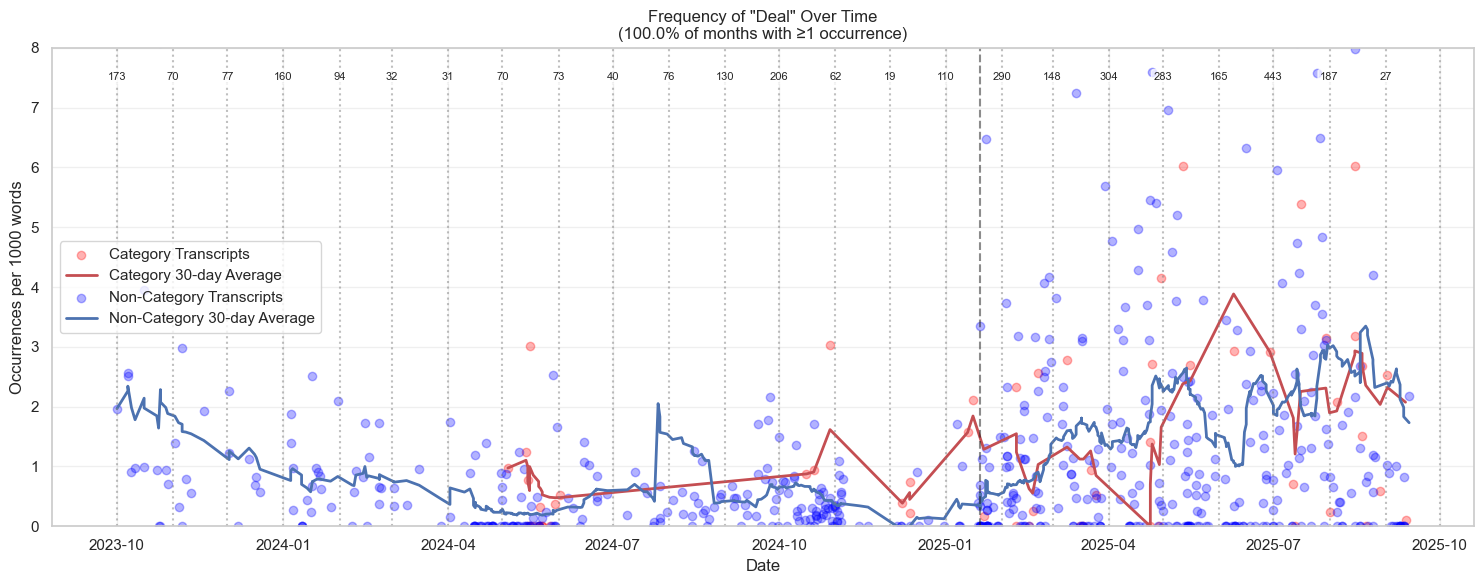


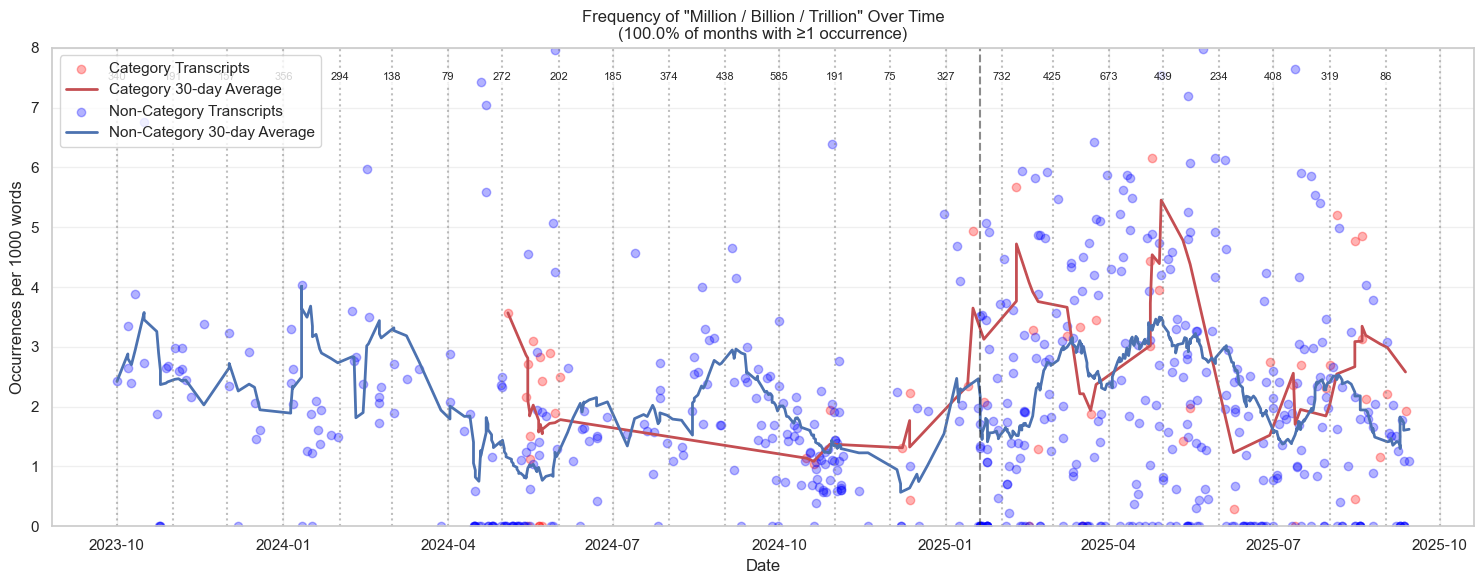


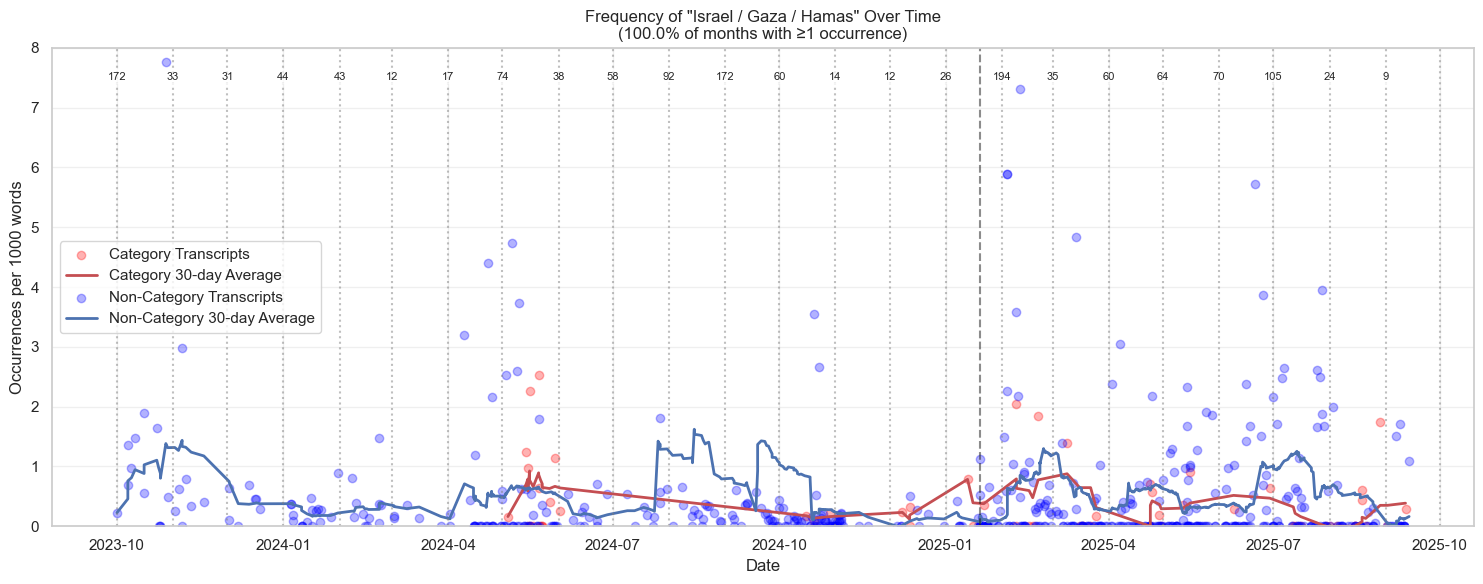


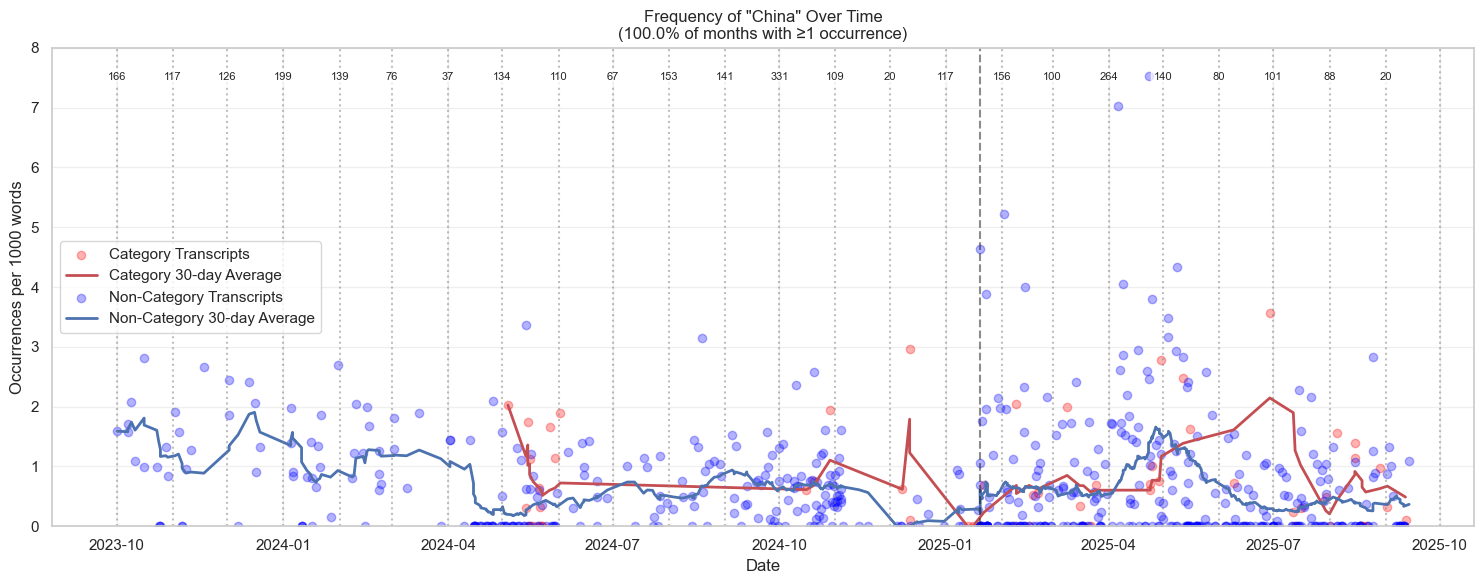


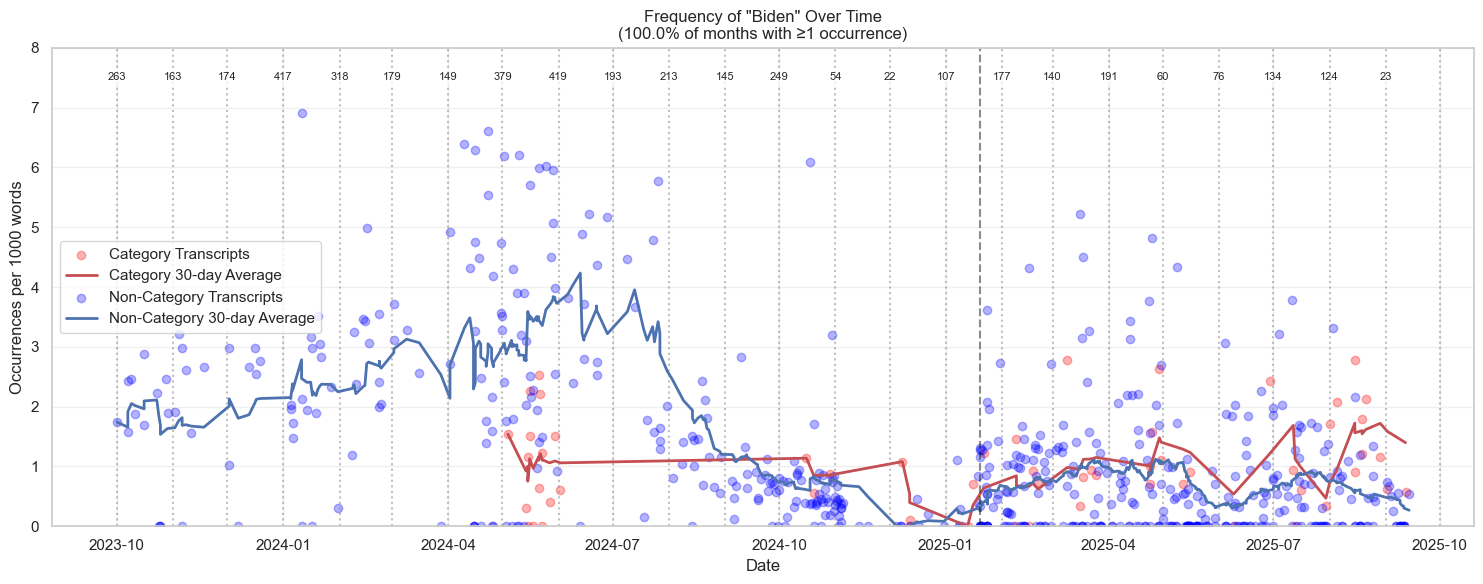


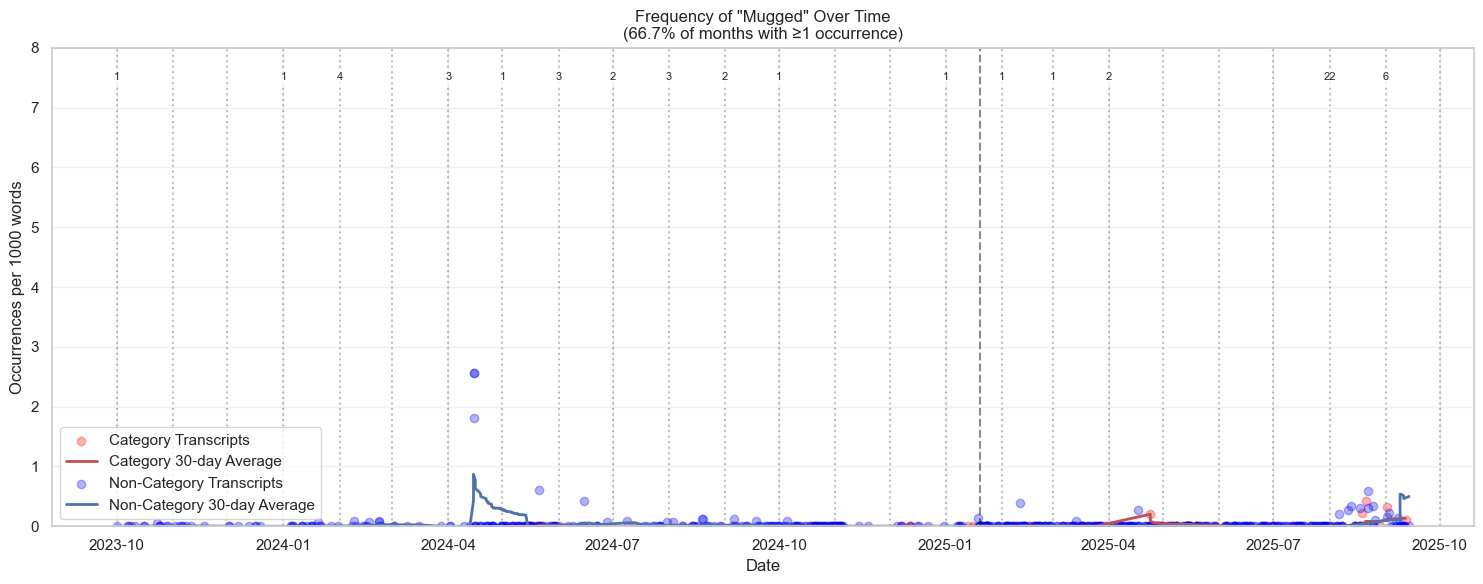


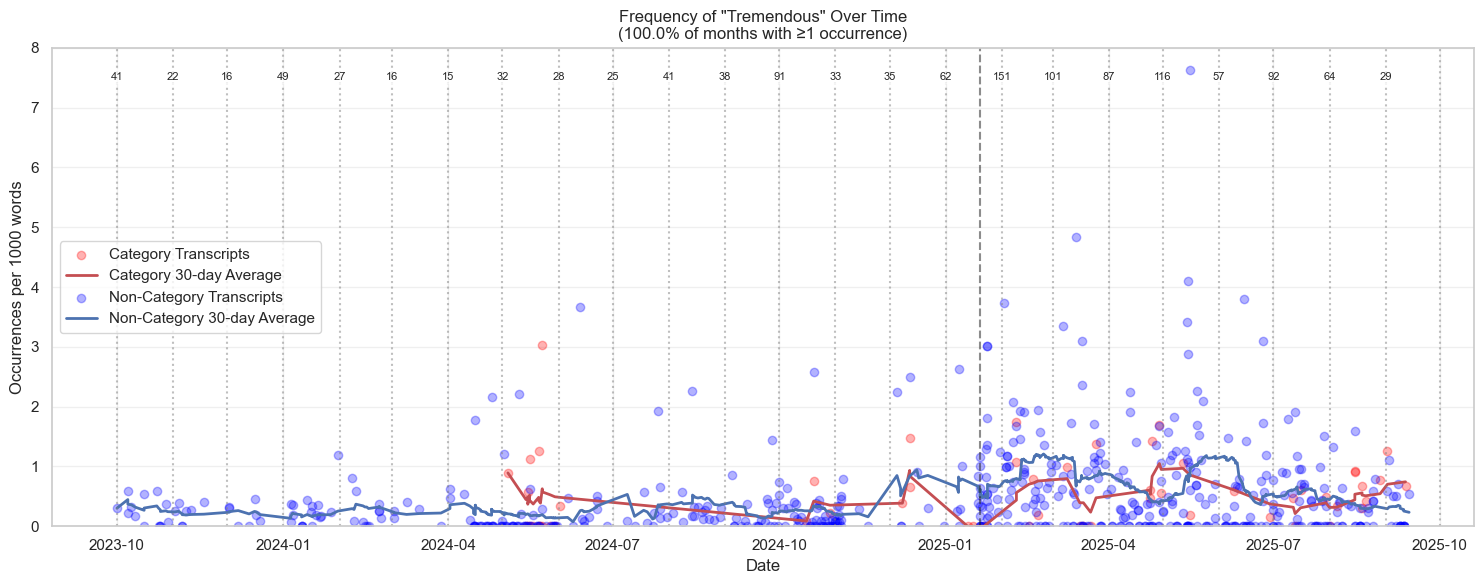


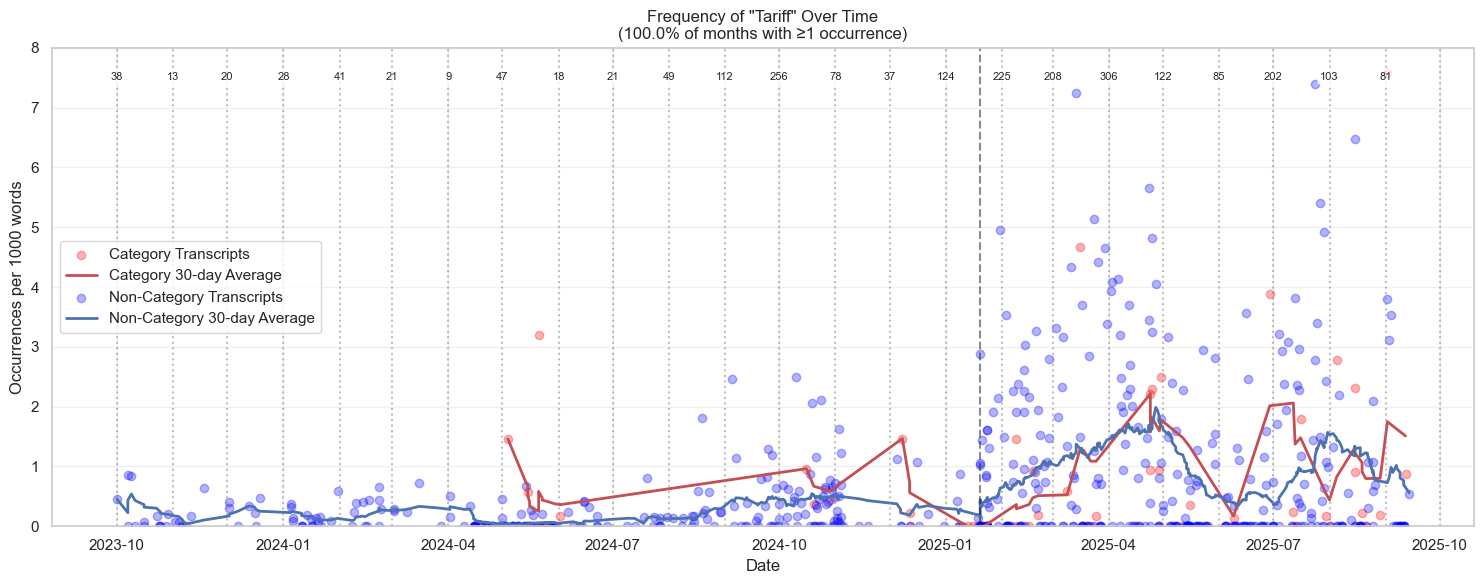


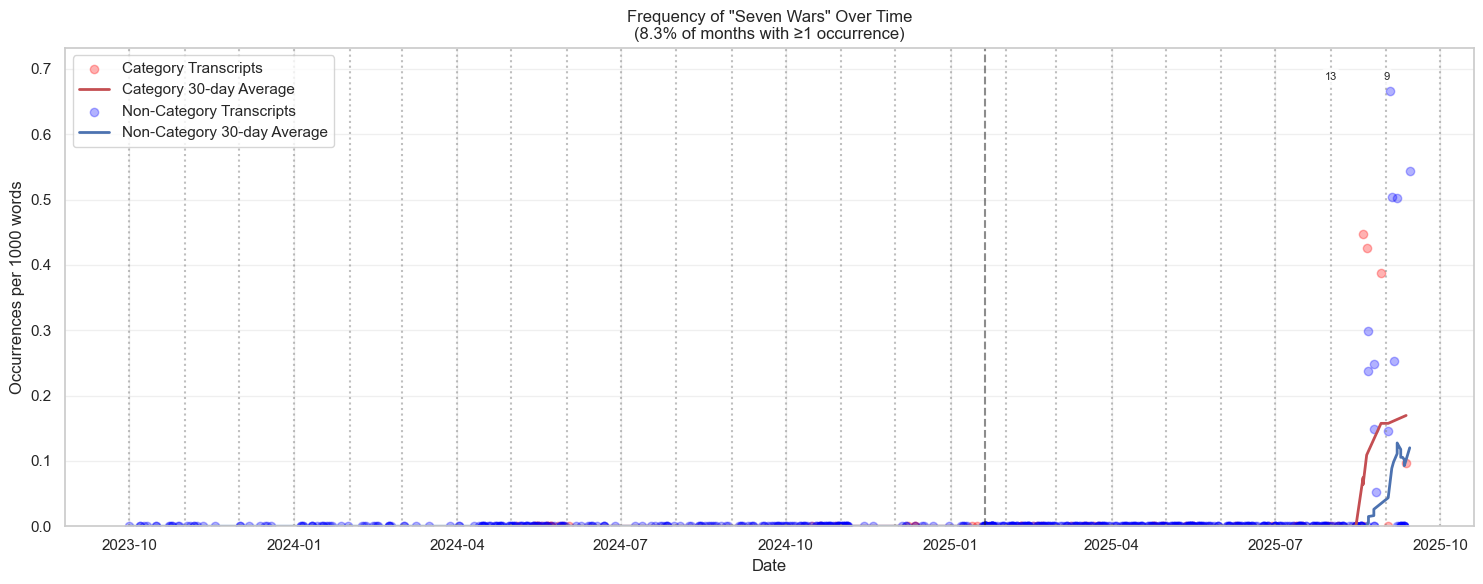


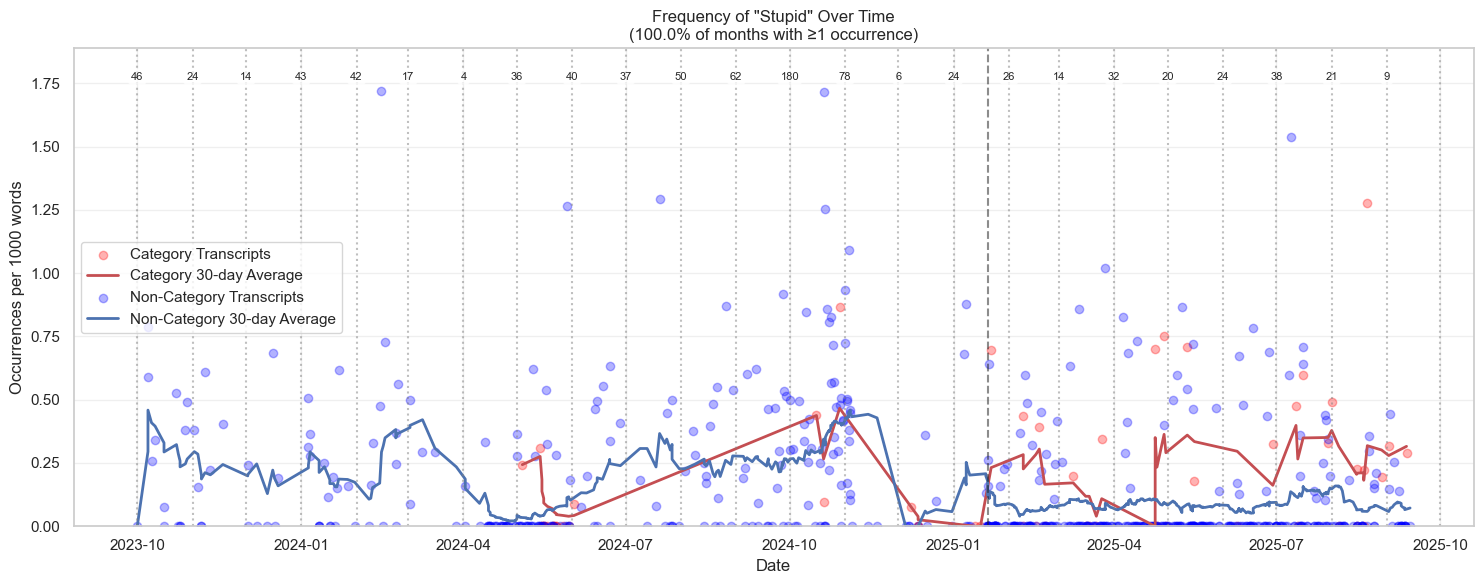


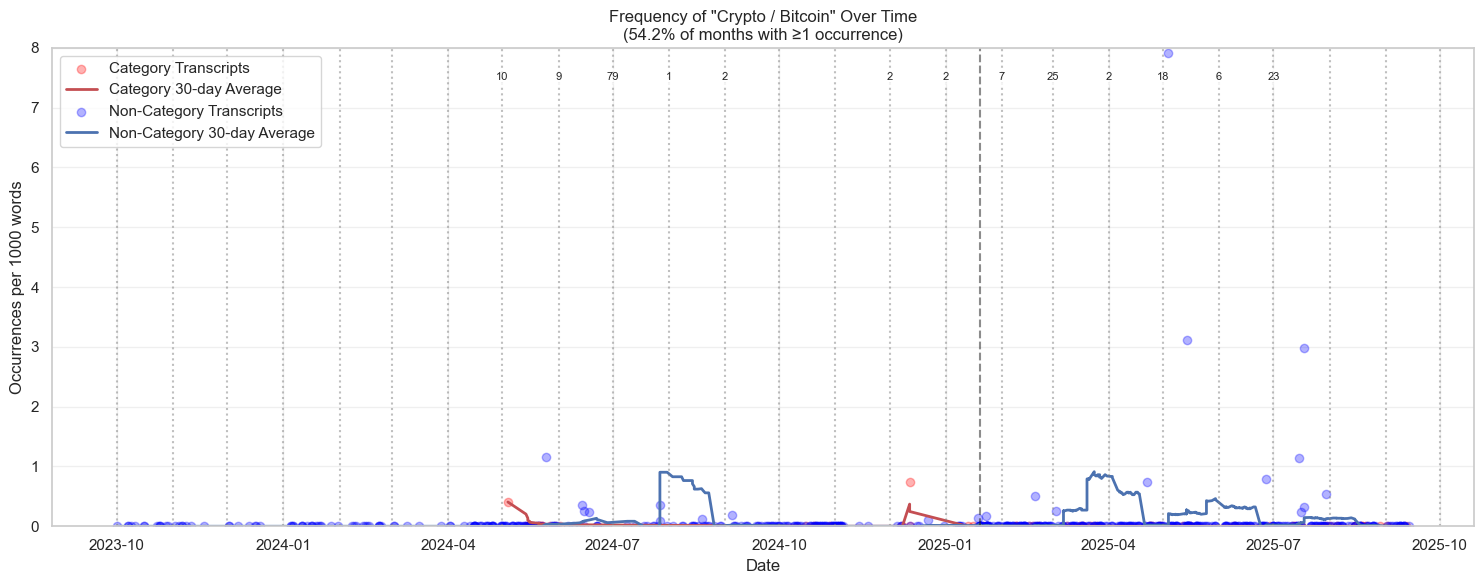


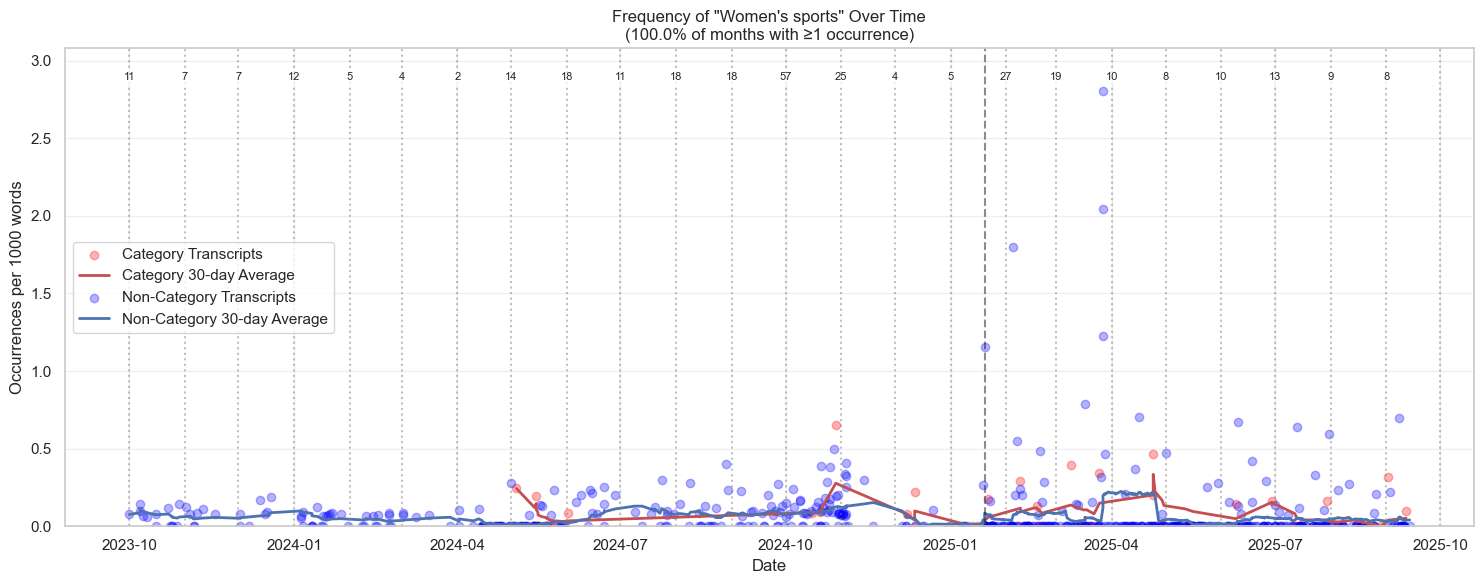


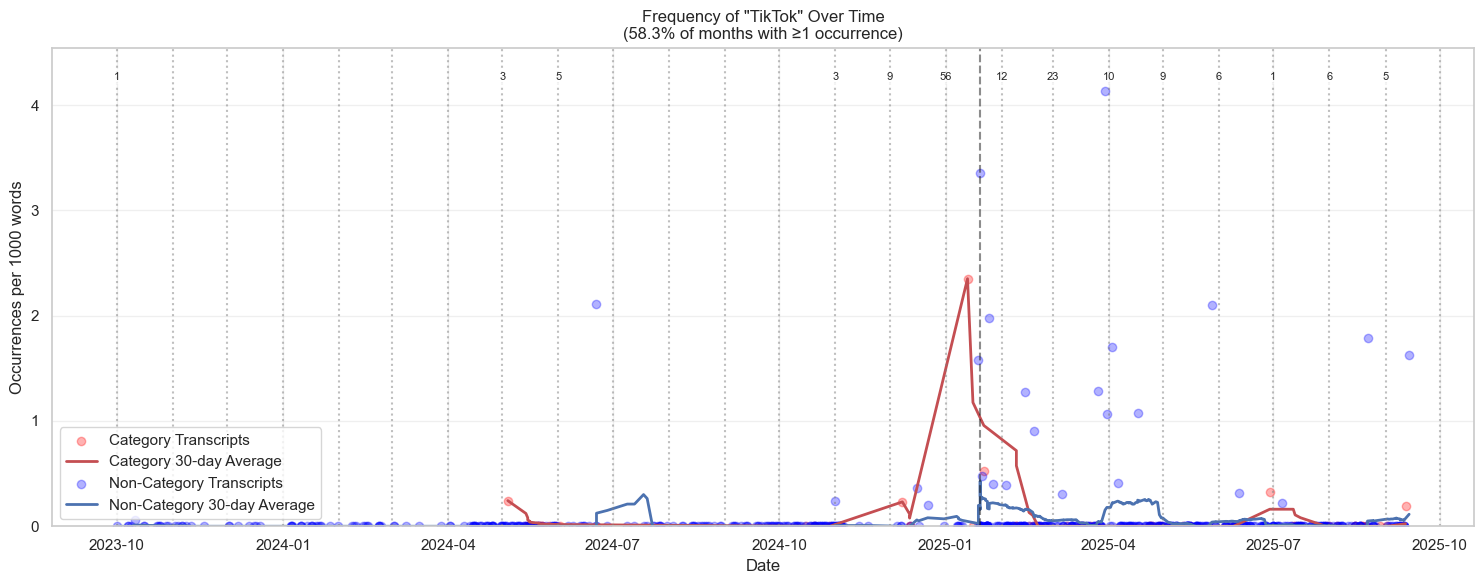


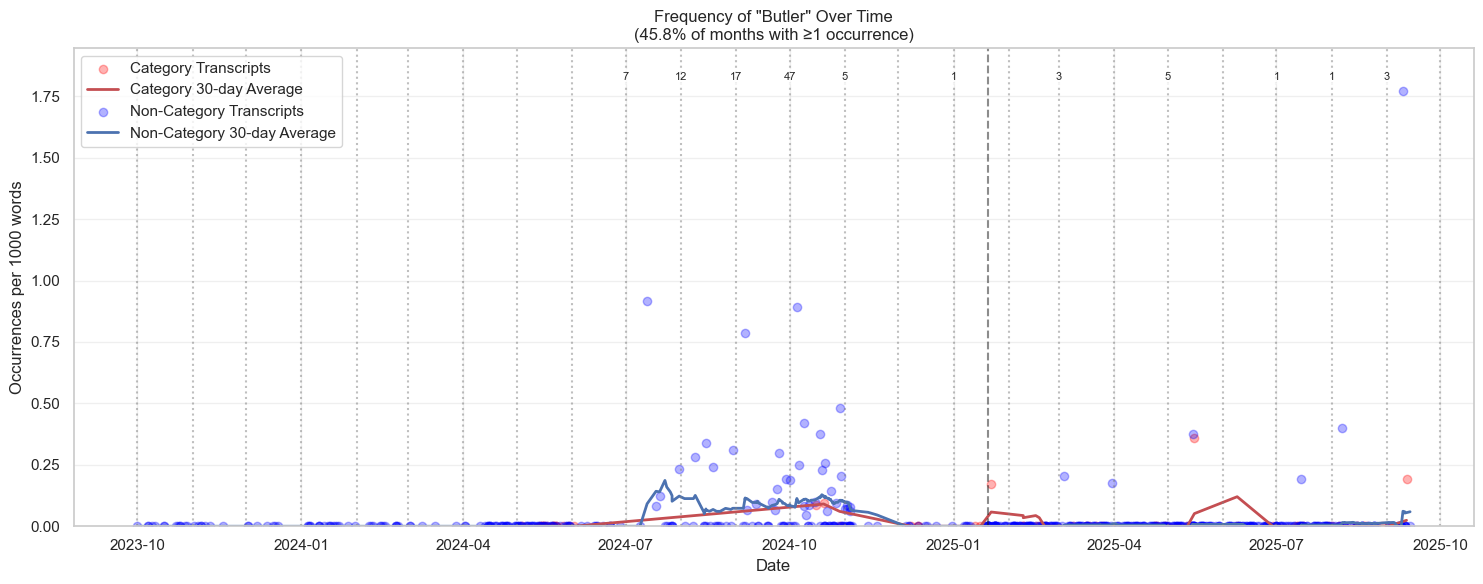


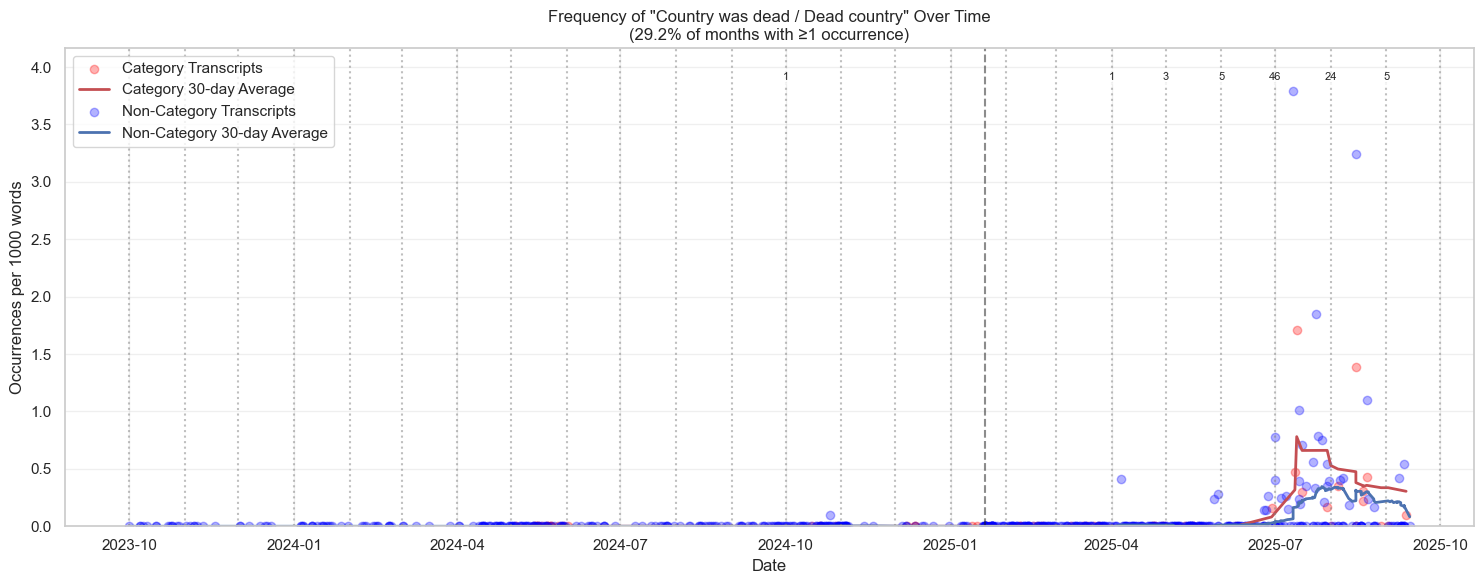

In [30]:
def plot_phrase_frequency_over_time(df_category, df_non_category, phrase, window=30):
    """Plot the frequency of a phrase over time with separate lines for category and non-category"""
    from IPython.display import HTML, display
    
    plt.figure(figsize=(15, 6))
    
    # Filter data to start from October 2023
    start_date = pd.Timestamp('2023-10-01')
    df_category = df_category[df_category['date'] >= start_date].copy()
    df_non_category = df_non_category[df_non_category['date'] >= start_date].copy()
    
    # Process category data
    df_category[f'{phrase}_freq'] = (df_category[phrase] / df_category['text_length']) * 1000
    category_series = df_category.set_index('date')[f'{phrase}_freq']
    category_rolling = category_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Process non-category data
    df_non_category[f'{phrase}_freq'] = (df_non_category[phrase] / df_non_category['text_length']) * 1000
    non_category_series = df_non_category.set_index('date')[f'{phrase}_freq']
    non_category_rolling = non_category_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot category data
    plt.scatter(category_series.index, category_series.values, alpha=0.3, color='red', label='Category Transcripts')
    plt.plot(category_rolling.index, category_rolling.values, 'r-', linewidth=2, label=f'Category {window}-day Average')
    
    # Plot non-category data
    plt.scatter(non_category_series.index, non_category_series.values, alpha=0.3, color='blue', label='Non-Category Transcripts')
    plt.plot(non_category_rolling.index, non_category_rolling.values, 'b-', linewidth=2, label=f'Non-Category {window}-day Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line for inauguration
    plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')
    
    # Add monthly vertical lines and counts
    combined_df = pd.concat([df_category, df_non_category])
    if not combined_df.empty:
        date_range = pd.date_range(
            start=combined_df['date'].min().replace(day=1),
            end=combined_df['date'].max() + pd.DateOffset(months=1),
            freq='MS'  # Month start
        )
        
        # Calculate monthly statistics
        combined_df['year_month'] = combined_df['date'].dt.to_period('M')
        monthly_stats = combined_df.groupby('year_month').agg({
            phrase: 'sum',
            'date': 'count'
        }).rename(columns={'date': 'transcript_count'})
        
        # Calculate % of months with 1+ occurrence
        months_with_occurrence = (monthly_stats[phrase] >= 1).sum()
        total_months = len(monthly_stats)
        pct_months_with_occurrence = (months_with_occurrence / total_months * 100) if total_months > 0 else 0
        
        # Add monthly vertical lines and counts
        for date in date_range:
            plt.axvline(x=date, color='gray', linestyle=':', alpha=0.5)
            
            # Get monthly count for this date
            period = date.to_period('M')
            if period in monthly_stats.index:
                monthly_count = monthly_stats.loc[period, phrase]
                if monthly_count > 0:
                    # Position text at top of plot
                    ymax = min(8, max(
                        df_category[f'{phrase}_freq'].max() if not df_category.empty else 0,
                        df_non_category[f'{phrase}_freq'].max() if not df_non_category.empty else 0
                    ) * 1.1)
                    plt.text(date, ymax * 0.95, str(int(monthly_count)), 
                            ha='center', va='top', fontsize=8, 
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        # Add percentage to title
        plt.title(f'Frequency of "{phrase}" Over Time\n({pct_months_with_occurrence:.1f}% of months with ≥1 occurrence)')
    
    # Auto-adjust y-axis limit up to max of 8
    ymax = min(8, max(
        df_category[f'{phrase}_freq'].max() if not df_category.empty else 0,
        df_non_category[f'{phrase}_freq'].max() if not df_non_category.empty else 0
    ) * 1.1)  # Add 10% padding
    plt.ylim(0, ymax)
    
    plt.tight_layout()
    
    # Save plot to base64 string for embedding in HTML
    import io
    import base64
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    plot_data = base64.b64encode(buf.read()).decode()
    plt.close()  # Close the figure to free memory
    
    # Create collapsible HTML
    html = f"""
    <details>
        <summary style="cursor: pointer; font-weight: bold; font-size: 14px; padding: 5px;">
            📊 {phrase} - Frequency Over Time
        </summary>
        <div style="margin-top: 10px;">
            <img src="data:image/png;base64,{plot_data}" style="max-width: 100%; height: auto;">
        </div>
    </details>
    """
    
    display(HTML(html))

# Plot time series for all phrases, sorted by frequency
phrase_freqs = {}
for phrase in SEARCH_PHRASES.keys():
    # Calculate average frequency across all data
    category_freq = (df_category[phrase].sum() / df_category['text_length'].sum()) * 1000 if not df_category.empty and df_category['text_length'].sum() > 0 else 0
    non_category_freq = (df_non_category[phrase].sum() / df_non_category['text_length'].sum()) * 1000 if not df_non_category.empty and df_non_category['text_length'].sum() > 0 else 0
    phrase_freqs[phrase] = (category_freq + non_category_freq) / 2

for phrase in phrase_freqs:
    plot_phrase_frequency_over_time(df_category, df_non_category, phrase)

Expected length from category data: 4399 words


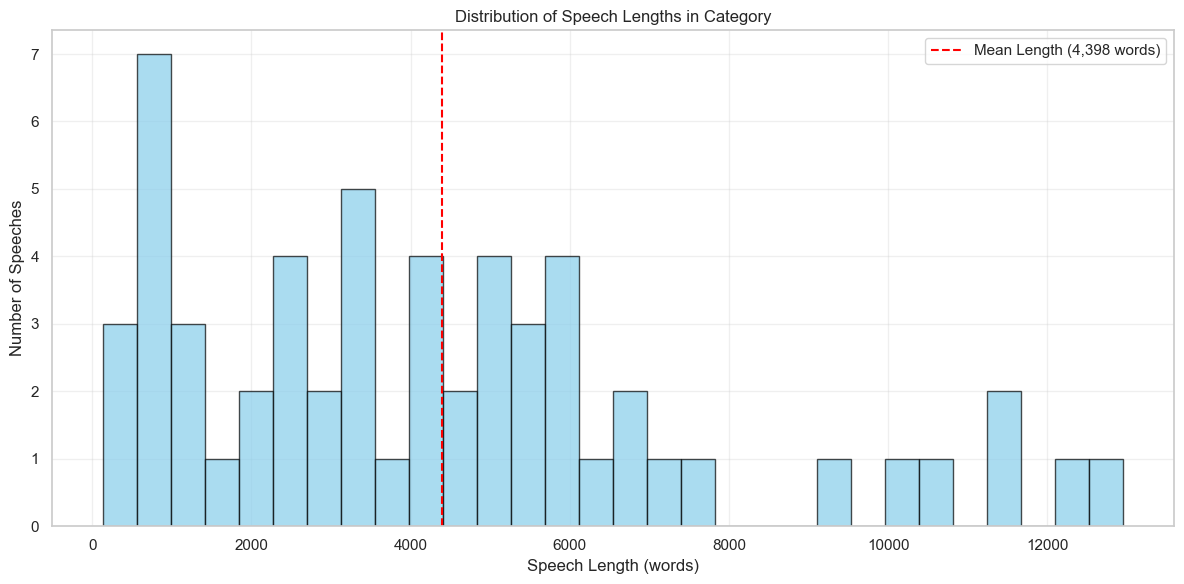

In [34]:
# Calculate expected length from the chosen category
expected_length = df_category['text_length'].mean()
print(f"Expected length from category data: {expected_length:.0f} words")

# Show histogram of category lengths
plt.figure(figsize=(12, 6))
plt.hist(df_category['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=expected_length, color='red', linestyle='--', label=f'Mean Length ({int(expected_length):,} words)')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title(f'Distribution of Speech Lengths in Category')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Poisson Predictions

The most naive approach is to use the past frequency of a phrase over a given time period to forecast the probability of a phrase occurring during the expected length of a future speech. Using the Poisson distribution, we assume each word is independent and identically distributed. This allows us to compute threshold probabilities for a phrase occurring a given number of times, which can be compared to the prediction market's implied probability. However, this approach does not account for the clear dependence between words in a speech. This approach can still be useful for analyzing mentions where mostly independent occurrences might be expected (America, God, etc.) 

In [35]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with likelihoods using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate likelihoods using Poisson PMF
        def poisson_ge_k(lambda_, k):
            return 1 - stats.poisson.cdf(k-1, lambda_)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(≥1)': poisson_ge_k(expected, 1),
            'P(≥3)': poisson_ge_k(expected, 3),
            'P(≥4)': poisson_ge_k(expected, 4),
            'P(≥5)': poisson_ge_k(expected, 5),
            'P(≥15)': poisson_ge_k(expected, 15)
        })
    
    return pd.DataFrame(predictions)

In [43]:


length = 4399

# Calculate predictions from different data sources
predictions_all = calculate_poisson_predictions(df, length)
predictions_category = calculate_poisson_predictions(df_category, length)
predictions_post_all = calculate_poisson_predictions(df_all_post, length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['P(≥1)'] = formatted['P(≥1)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥3)'] = formatted['P(≥3)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥4)'] = formatted['P(≥4)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥5)'] = formatted['P(≥5)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥15)'] = formatted['P(≥15)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected',
        'P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on all appearances:")
display(format_prediction_table(predictions_all, 'all'))

print("\nPredictions based on all speeches:")
display(format_prediction_table(predictions_category, 'post-inauguration-speeches'))

print("\nPredictions based on all post-inauguration appearances:")
display(format_prediction_table(predictions_post_all, 'post-inauguration-all'))

Predictions based on all appearances:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
1,Million / Billion / Trillion,10.12,100.0%,100.0%,99.0%,97.0%,9.0%,2.30,7594
4,Biden,5.85,100.0%,93.0%,83.0%,69.0%,0.0%,1.33,4389
0,Deal,4.39,99.0%,81.0%,64.0%,45.0%,0.0%,1.00,3295
3,China,4.04,98.0%,77.0%,57.0%,38.0%,0.0%,0.92,3031
7,Tariff,3.00,95.0%,58.0%,35.0%,19.0%,0.0%,0.68,2252
2,Israel / Gaza / Hamas,1.96,86.0%,31.0%,13.0%,5.0%,0.0%,0.44,1467
6,Tremendous,1.70,82.0%,24.0%,9.0%,3.0%,0.0%,0.39,1274
9,Stupid,1.19,69.0%,12.0%,3.0%,1.0%,0.0%,0.27,890
11,Women's sports,0.43,35.0%,1.0%,0.0%,0.0%,0.0%,0.10,326
10,Crypto / Bitcoin,0.25,22.0%,0.0%,0.0%,0.0%,0.0%,0.06,186



Predictions based on all speeches:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
1,Million / Billion / Trillion,11.65,100.0%,100.0%,100.0%,99.0%,20.0%,2.65,664
0,Deal,6.14,100.0%,94.0%,86.0%,73.0%,0.0%,1.40,350
4,Biden,4.72,99.0%,85.0%,69.0%,51.0%,0.0%,1.07,269
3,China,4.26,99.0%,80.0%,62.0%,42.0%,0.0%,0.97,243
7,Tariff,4.25,99.0%,80.0%,61.0%,42.0%,0.0%,0.97,242
6,Tremendous,2.58,92.0%,48.0%,26.0%,12.0%,0.0%,0.59,147
2,Israel / Gaza / Hamas,1.84,84.0%,28.0%,12.0%,4.0%,0.0%,0.42,105
9,Stupid,1.04,64.0%,9.0%,2.0%,0.0%,0.0%,0.24,59
11,Women's sports,0.51,40.0%,2.0%,0.0%,0.0%,0.0%,0.12,29
12,TikTok,0.33,28.0%,0.0%,0.0%,0.0%,0.0%,0.08,19



Predictions based on all post-inauguration appearances:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
1,Million / Billion / Trillion,12.67,100.0%,100.0%,100.0%,100.0%,29.0%,2.88,3542
0,Deal,6.89,100.0%,97.0%,91.0%,82.0%,0.0%,1.57,1926
7,Tariff,5.18,99.0%,89.0%,76.0%,59.0%,0.0%,1.18,1447
3,China,3.76,98.0%,72.0%,52.0%,32.0%,0.0%,0.85,1051
4,Biden,3.62,97.0%,70.0%,49.0%,30.0%,0.0%,0.82,1013
6,Tremendous,2.67,93.0%,50.0%,28.0%,13.0%,0.0%,0.61,747
2,Israel / Gaza / Hamas,2.07,87.0%,34.0%,16.0%,6.0%,0.0%,0.47,579
9,Stupid,0.71,51.0%,4.0%,1.0%,0.0%,0.0%,0.16,198
12,TikTok,0.39,33.0%,1.0%,0.0%,0.0%,0.0%,0.09,110
11,Women's sports,0.38,32.0%,1.0%,0.0%,0.0%,0.0%,0.09,107


## Negative Binomial 

A more general model that accounts for overdispersion. The dispersion parameter r is estimated using the method of moments, and it controls how much extra variance there is compared to a Poisson distribution. As r approaches infinity, the negative binomial converges to a Poisson distribution (in practice we use r=100 to approximate this). Values closer to 0 indicate that the data is overdispersed.

In [47]:

def calculate_negative_binomial_predictions(df, avg_length):
    """Calculate predictions using Negative Binomial distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Skip phrases that don't exist in the dataframe
        if phrase not in df.columns:
            continue
            
        # Calculate rate per word and variance
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in speech of avg_length
        expected = rate_per_word * avg_length
        
        # Calculate sample variance to estimate overdispersion
        counts_per_speech = df[phrase] / df['text_length'] * avg_length
        sample_variance = counts_per_speech.var()
        
        if sample_variance > expected and expected > 0:  # Check for overdispersion
            # Calculate r parameter for negative binomial using method of moments
            r = max(0.1, expected**2 / (sample_variance - expected))
            p = r/(r + expected)
        else:
            # If no overdispersion, fallback to quasi-Poisson
            r = 100
            p = r/(r + expected)
        
        # Calculate likelihoods using Negative Binomial CDF
        def nb_ge_k(r, p, k):
            return 1 - stats.nbinom.cdf(k-1, r, p)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Dispersion (r)': r,
            'Sample Variance': sample_variance,
            'P(≥1)': nb_ge_k(r, p, 1)
        })
    
    return pd.DataFrame(predictions)


def format_prediction_table(df):
    """Format prediction table with percentages"""
    formatted = df.copy()
    formatted = formatted.round(3)
    
    # Format probability columns as percentages
    formatted['P(≥1)'] = formatted['P(≥1)'].map('{:.1%}'.format)
    
    # Round other numeric columns
    formatted['Expected'] = formatted['Expected'].round(2)
    if 'Dispersion (r)' in formatted.columns:
        formatted['Dispersion (r)'] = formatted['Dispersion (r)'].round(2)
        formatted['Sample Variance'] = formatted['Sample Variance'].round(2)
    
    return formatted.sort_values('Expected', ascending=False)

def compare_models(poisson_df, nb_df):
    """Compare Poisson and Negative Binomial predictions"""
    comparison = pd.DataFrame()
    comparison['Phrase'] = poisson_df['Phrase']
    comparison['Expected'] = poisson_df['Expected']
    
    # Convert percentage strings back to floats for calculations
    comparison['Poisson P(≥1)'] = poisson_df['P(≥1)'].astype(float)
    comparison['NB P(≥1)'] = nb_df['P(≥1)'].astype(float)
    comparison['Δ P(≥1)'] = (comparison['NB P(≥1)'] - comparison['Poisson P(≥1)']) * 100
    
    comparison['Dispersion (r)'] = nb_df['Dispersion (r)']
    comparison['Sample Variance'] = nb_df['Sample Variance']
    
    # Format probability columns as percentages
    comparison['Poisson P(≥1)'] = comparison['Poisson P(≥1)'].map('{:.1%}'.format)
    comparison['NB P(≥1)'] = comparison['NB P(≥1)'].map('{:.1%}'.format)
    
    return comparison.round(3).sort_values('Δ P(≥1)', ascending=True)

def plot_distribution_comparison(phrase, poisson_df, nb_df, max_k=10):
    """Plot comparison of Poisson and Negative Binomial distributions"""
    phrase_data = poisson_df[poisson_df['Phrase'] == phrase].iloc[0]
    nb_data = nb_df[nb_df['Phrase'] == phrase].iloc[0]
    
    lambda_ = phrase_data['Expected']
    r = nb_data['Dispersion (r)']
    p = r/(r + lambda_)
    
    k = np.arange(0, max_k+1)
    poisson_pmf = stats.poisson.pmf(k, lambda_)
    nb_pmf = stats.nbinom.pmf(k, r, p)
    
    plt.figure(figsize=(10, 6))
    plt.bar(k-0.2, poisson_pmf, width=0.4, alpha=0.5, label='Poisson', color='blue')
    plt.bar(k+0.2, nb_pmf, width=0.4, alpha=0.5, label='Negative Binomial', color='red')
    plt.title(f'Distribution Comparison for "{phrase}"')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Calculate predictions using both models
avg_speech_length = df_category['text_length'].mean()
print(f"using {avg_speech_length} speech length")

print("Negative Binomial Predictions based on all appearances:")
nb_predictions = calculate_negative_binomial_predictions(df, avg_speech_length)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on category:")
nb_predictions = calculate_negative_binomial_predictions(df_category, avg_speech_length)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on all appearances post inauguration:")
nb_predictions_all = calculate_negative_binomial_predictions(df_all_post, avg_speech_length)
display(format_prediction_table(nb_predictions_all))

poisson_predictions = calculate_poisson_predictions(df, avg_speech_length)

print("\nModel Comparison (Negative Binomial vs Poisson):")
display(compare_models(poisson_predictions, nb_predictions))

# Plot distributions for most overdispersed phrases - only use phrases that exist in the data
available_phrases = ['Border', 'America', 'God', 'Rigged', 'Hell']
most_overdispersed = nb_predictions[nb_predictions['Phrase'].isin(available_phrases)]
for _, row in most_overdispersed.iterrows():
    # Get parameters for both distributions
    phrase_data = poisson_predictions[poisson_predictions['Phrase'] == row['Phrase']].iloc[0]
    lambda_ = phrase_data['Expected']
    r = row['Dispersion (r)']
    p = r/(r + lambda_)
    
    # Find where probability becomes negligible (< 0.1%)
    k = 0
    while stats.nbinom.pmf(k, r, p) > 0.001 or stats.poisson.pmf(k, lambda_) > 0.001:
        k += 1
    
    # Ensure minimum k of 30 for 'America' to show full distribution
    if row['Phrase'] == 'America':
        k = max(k, 60)
    
    print(f"\nDistribution comparison for {row['Phrase']} (r = {row['Dispersion (r)']:.2f}):")
    plot_distribution_comparison(row['Phrase'], poisson_predictions, nb_predictions, max_k=k)

using 4398.894736842105 speech length
Negative Binomial Predictions based on all appearances:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
1,Million / Billion / Trillion,10.12,1.18,97.32,93.0%
4,Biden,5.85,0.68,56.32,78.5%
0,Deal,4.39,0.18,112.52,43.9%
3,China,4.04,1.04,19.75,80.8%
7,Tariff,3.00,0.38,26.75,56.4%
2,Israel / Gaza / Hamas,1.96,0.10,42.67,26.1%
6,Tremendous,1.70,0.14,22.72,29.9%
9,Stupid,1.19,8.01,1.36,66.9%
11,Women's sports,0.44,0.57,0.76,27.6%
10,Crypto / Bitcoin,0.25,0.10,26.36,11.7%


Negative Binomial Predictions based on category:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
1,Million / Billion / Trillion,11.65,2.12,75.66,98.1%
0,Deal,6.14,0.89,48.37,84.2%
4,Biden,4.72,3.11,11.88,94.3%
3,China,4.26,1.70,14.98,88.1%
7,Tariff,4.25,0.53,38.37,68.7%
6,Tremendous,2.58,1.50,7.01,77.7%
2,Israel / Gaza / Hamas,1.84,0.58,7.70,56.3%
9,Stupid,1.03,2.12,1.54,57.0%
11,Women's sports,0.51,100.00,0.38,39.8%
12,TikTok,0.33,0.10,2.00,13.6%


Negative Binomial Predictions based on all appearances post inauguration:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
1,Million / Billion / Trillion,12.67,1.50,119.74,96.6%
0,Deal,6.89,0.29,168.66,60.9%
7,Tariff,5.18,0.78,39.68,79.4%
3,China,3.76,0.81,21.14,75.5%
4,Biden,3.62,0.98,16.98,78.1%
6,Tremendous,2.67,0.22,34.49,43.7%
2,Israel / Gaza / Hamas,2.07,0.10,47.12,26.5%
9,Stupid,0.71,2.02,0.96,45.5%
12,TikTok,0.39,0.10,2.73,14.8%
11,Women's sports,0.38,0.18,1.20,18.5%



Model Comparison (Negative Binomial vs Poisson):


,Phrase,Expected,Poisson P(≥1),NB P(≥1),Δ P(≥1),Dispersion (r),Sample Variance
2,Israel / Gaza / Hamas,1.956,85.9%,56.3%,-29.528,0.579,7.703
7,Tariff,3.002,95.0%,68.7%,-26.292,0.528,38.371
10,Crypto / Bitcoin,0.248,22.0%,6.9%,-15.021,0.100,0.238
0,Deal,4.392,98.8%,84.2%,-14.600,0.893,48.370
9,Stupid,1.186,69.5%,57.0%,-12.517,2.119,1.541
3,China,4.041,98.2%,88.1%,-10.115,1.695,14.985
4,Biden,5.851,99.7%,94.3%,-5.378,3.108,11.884
12,TikTok,0.199,18.0%,13.6%,-4.375,0.100,2.003
6,Tremendous,1.698,81.7%,77.7%,-3.985,1.502,7.007
1,Million / Billion / Trillion,10.123,100.0%,98.1%,-1.890,2.120,75.659


## Recent Usage Context

In [48]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Deal' ===

Date: 2025-09-14 (press gaggle)
Context: ...I think they will, but right now they're talking and they're not doing. Look, they're buying oil from Russia. We're not buying oil from Russia. They're buying a lot of oil from Russia. That's not the deal.

But when you say impact, impact of what?

Oh, impasse? It's not gonna matter because when they go on, they're gonna be very, very strong. So it's not gonna matter. Maggie, go ahead.

Right. Right.

...

Date: 2025-09-14 (press gaggle)
Context: ...say impact, impact of what?

Oh, impasse? It's not gonna matter because when they go on, they're gonna be very, very strong. So it's not gonna matter. Maggie, go ahead.

Right. Right.

That's not the deal though.

The deal is they're not suppose, whether it's natural gas or whether it's cigarettes, I don't care, they're not supposed to be buying from Russia. We're spending a lot of money giving. Now, ...

Date: 2025-09-14 (press gaggle)
Context: ... of what?

Oh, i

## Per-Speech Frequencies


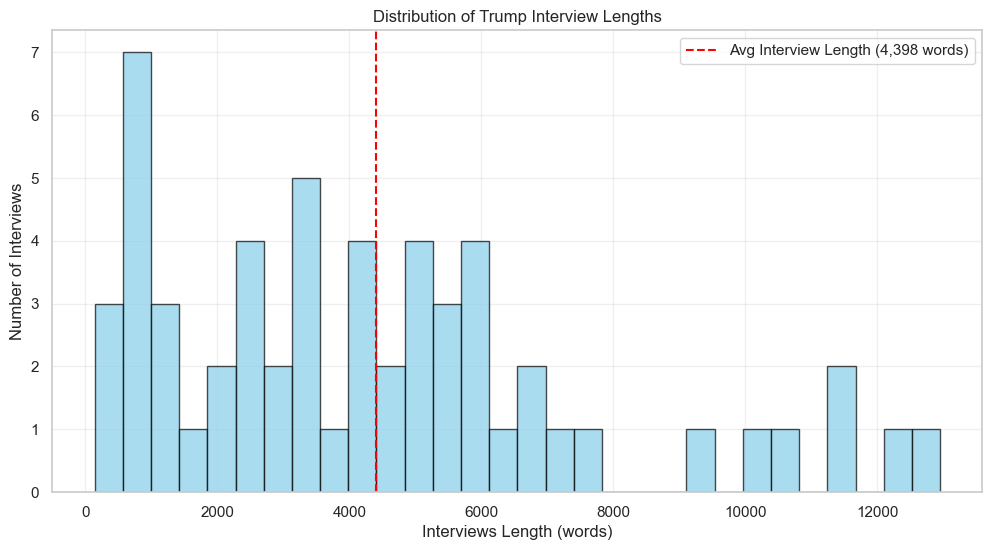

In [50]:
interview_mean_length = df_interviews['text_length'].mean()

# Plot distribution of speech lengths with interview average marked
plt.figure(figsize=(12, 6))
plt.hist(df_interviews['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=interview_mean_length, color='red', linestyle='--', label=f'Avg Interview Length ({int(interview_mean_length):,} words)')
plt.xlabel('Interviews Length (words)')
plt.ylabel('Number of Interviews')
plt.title('Distribution of Trump Interview Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [54]:
# Calculate percentage of appearances containing each phrase at least once
phrase_percentages = {}

# Filter for appearances since May 1
df_since_may = df[df['date'] >= '2025-05-01']


for phrase in SEARCH_PHRASES.keys():
    all_pct = (df[phrase] >= 1).mean() * 100
    category_pct = (df_category[phrase] >= 1).mean() * 100
    post_pct = (df_all_post[phrase] >= 1).mean() * 100
    since_may_pct = (df_since_may[phrase] >= 1).mean() * 100 if len(df_since_may) > 0 else 0
    phrase_percentages[phrase] = {
        'All Appearances': all_pct,
        '{CATEGORY_OF_INTEREST} Only': category_pct, 
        'Post-Inauguration': post_pct,
        'Since May 1': since_may_pct,
    }

# Create DataFrame and sort by percentage in all appearances
phrase_df = pd.DataFrame.from_dict(phrase_percentages, orient='index')
phrase_df = phrase_df.sort_values('All Appearances', ascending=False)
phrase_df.index.name = 'Phrase'

# Format table for display
styled_df = phrase_df.style.format({
    'All Appearances': '{:.1f}%'.format,
    '{CATEGORY_OF_INTEREST} Only': '{:.1f}%'.format,
    'Post-Inauguration': '{:.1f}%'.format,
    'Since May 1': '{:.1f}%'.format,
})

print("Percentage of Appearances Containing Each Phrase:")
display(styled_df)


Percentage of Appearances Containing Each Phrase:


,All Appearances,{CATEGORY_OF_INTEREST} Only,Post-Inauguration,Since May 1
Phrase,,,,
Million / Billion / Trillion,77.7%,87.7%,75.9%,75.3%
Biden,70.4%,84.2%,60.8%,55.7%
Deal,69.1%,71.9%,68.8%,68.0%
Tremendous,61.9%,68.4%,64.9%,60.8%
China,57.7%,70.2%,50.4%,45.9%
Tariff,51.8%,57.9%,52.9%,46.9%
Israel / Gaza / Hamas,47.4%,54.4%,37.0%,36.1%
Stupid,36.0%,47.4%,24.1%,27.3%
Women's sports,30.3%,35.1%,16.7%,14.9%


In [33]:
# Get 10 shortest interviews
shortest_interviews = df_interviews.nsmallest(10, 'text_length')[['file', 'text_length', 'date']]
print("\nShortest 10 Interviews:")
print(shortest_interviews)



Shortest 10 Interviews:
                                                                                     file  \
481  2025-02-16_jamie_little_of_fox_sports_interviews_donald_trump_at_the_daytona_500.txt   
508        2024-05-15_tom_hauser_of_kstp-tv_st_paul_minnesota_interviews_donald_trump.txt   
485                    2024-05-23_lawrence_jones_interviews_donald_trump_in_the_bronx.txt   
468           2025-07-13_emily_austin_of_dazn_interviews_donald_trump_at_a_fifa_match.txt   
492    2024-05-16_charles_benson_of_scripps_news_interviews_donald_trump_in_milwaukee.txt   
486                  2024-05-21_josh_meny_of_ktvn_2_news_reno_interviews_donald_trump.txt   
473          2024-05-23_tara_rosenblum_of_news_12_westchester_interviews_donald_trump.txt   
523         2024-05-16_liz_collin_of_alpha_news_in_minnesota_interviews_donald_trump_.txt   
498   2025-02-09_bret_baier_of_fox_news_interviews_donald_trump_before_super_bowl_lix.txt   
479            2024-05-18_steven_dial_of_kdfw

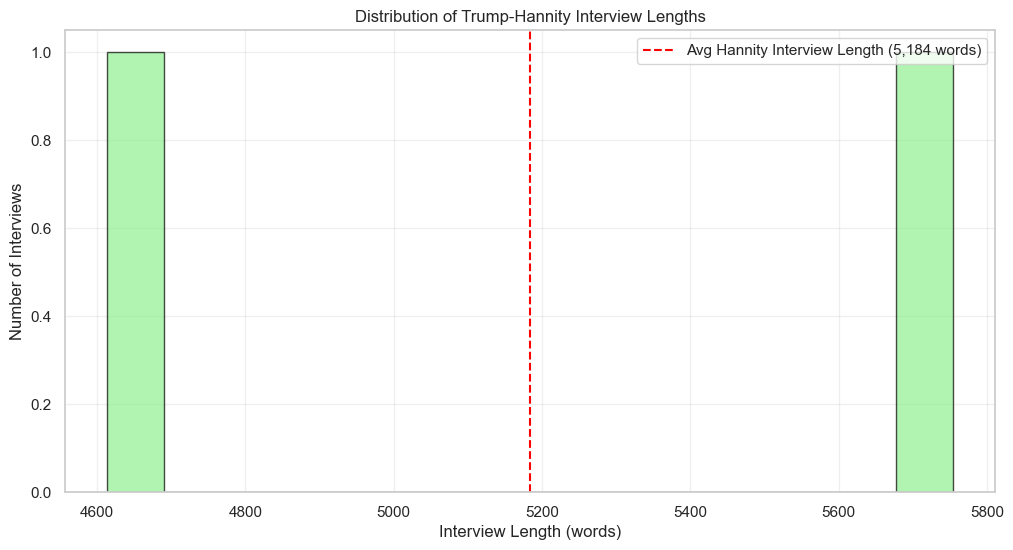


Hannity Interviews:
                                                                                   file  \
226                   2024-10-29_sean_hannity_interviews_donald_trump_at_mar-a-lago.txt   
220  2025-01-22_sean_hannity_interviews_donald_trump_in_the_oval_office_on_fox_news.txt   

     text_length       date  
226         4614 2024-10-29  
220         5754 2025-01-22  


In [ ]:
# Find Hannity interviews
hannity_interviews = df_interviews[df_interviews['file'].str.contains('hannity', case=False)]

# Plot distribution of Hannity interview lengths
plt.figure(figsize=(12, 6))
plt.hist(hannity_interviews['text_length'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(x=hannity_interviews['text_length'].mean(), color='red', linestyle='--', 
            label=f'Avg Hannity Interview Length ({int(hannity_interviews["text_length"].mean()):,} words)')
plt.xlabel('Interview Length (words)')
plt.ylabel('Number of Interviews')
plt.title('Distribution of Trump-Hannity Interview Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display Hannity interview details
print("\nHannity Interviews:")
print(hannity_interviews[['file', 'text_length', 'date']].sort_values('date'))
